# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = './train.p'
validation_file= './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape # (32, 32, 3)

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

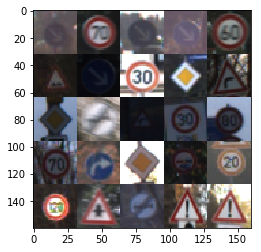

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import numpy as np
import math
from PIL import Image

# this function borrows heavily from the deep learning foundations nanodegree final project helper
def images_square_grid(images, mode, scale=False):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    if scale:
        images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image.astype('uint8'), mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

indexes = list(map(int, np.random.sample((25,)) * n_train))
sample_images = np.array(X_train)[indexes]
plt.imshow(images_square_grid(sample_images, 'RGB'))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

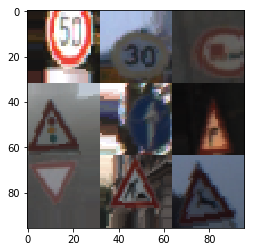

In [5]:
# set up a data generator for image augmentation
# I am rotating, shifting images from center, and zooming out.
# These operations seem most likely to cause better generalization.

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    fill_mode='nearest'
)
    
for batch_x, batch_y in datagen.flow(np.array(X_train), np.array(y_train), batch_size=9):
    plt.imshow(images_square_grid(batch_x, 'RGB'))
    break

In [7]:
### Normalize the image by centering on zero and reducing the range to -0.5 to 0.5
def normalize_image(image):
    return (np.array(image) / 255.) - 0.5

def normalize_images(images):
    return [normalize_image(image) for image in images]

X_train_normalized = normalize_images(X_train)
X_valid_normalized = normalize_images(X_valid)
X_test_normalized = normalize_images(X_test)

In [8]:
#make sure the normalized data looks ok
print(X_valid_normalized[500][20])

[[-0.33921569 -0.33921569 -0.3627451 ]
 [-0.33921569 -0.34313725 -0.3627451 ]
 [-0.34313725 -0.34313725 -0.36666667]
 [-0.3        -0.31960784 -0.34313725]
 [-0.06078431 -0.15490196 -0.17843137]
 [ 0.13137255 -0.08039216 -0.11176471]
 [ 0.09215686 -0.20980392 -0.24509804]
 [ 0.08823529 -0.20588235 -0.23333333]
 [ 0.21764706  0.0372549   0.02156863]
 [ 0.20588235  0.17843137  0.20588235]
 [-0.09607843 -0.04901961 -0.0372549 ]
 [-0.14313725 -0.13921569 -0.14705882]
 [-0.08039216 -0.08039216 -0.02156863]
 [-0.18235294 -0.17058824 -0.18235294]
 [-0.10392157 -0.10392157 -0.12745098]
 [ 0.2372549   0.21372549  0.21372549]
 [ 0.27254902  0.26470588  0.28039216]
 [-0.06470588 -0.02941176 -0.02941176]
 [-0.20588235 -0.16666667 -0.1627451 ]
 [-0.14705882 -0.15882353 -0.13137255]
 [-0.20196078 -0.18235294 -0.1627451 ]
 [-0.12352941 -0.13921569 -0.18627451]
 [ 0.23333333  0.15098039  0.1627451 ]
 [ 0.24117647  0.08823529  0.10392157]
 [ 0.10392157 -0.20980392 -0.21372549]
 [ 0.04901961 -0.28039216

In [9]:
# one-hot the labels

import sklearn.preprocessing

binarizer = sklearn.preprocessing.LabelBinarizer()
binarizer.fit(y_train)

y_train_onehot = binarizer.transform(y_train)
y_valid_onehot = binarizer.transform(y_valid)
y_test_onehot = binarizer.transform(y_test)

### Model Architecture

In [10]:
# hyperparameters
epochs = 32
batch_size = 64
learning_rate = 0.0001

In [16]:
# use a simplified Inception-style convolutional network
# I experimented with several activation functions,
# including relu, elu, and selu,
# finally settling on leaky relu.

import tensorflow as tf
from tensorflow.python.framework import ops

# might need to run this more than once :)
tf.reset_default_graph()

# another activation function, avoiding dead neurons
def leaky_relu(tensor, alpha=0.1):
    return tf.maximum(tensor * alpha, tensor)

# see https://arxiv.org/abs/1706.02515
# I experimented with this after reading the paper.
# I think that it did help with self-regularization, as promised,
# but was somewhat slower to learn. It may have worked better
# with the alpha dropout described in the paper.
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.67
        scale = 1.05
        return scale * tf.where(x >= 0.0, x, alpha * tf.nn.elu(x))

# allows for experimentation with activation functions
def activation(tensor):
    return leaky_relu(tensor)

def classifier(images, is_training=True):
    with tf.variable_scope('classifier'):
        
        # multiple paths a-la Inception.
        
        # path 1: large kernel size
        # A convolution with max pooling
        conv1_1 = tf.layers.conv2d(images, 8, 8, 1, padding='same', activation=None)
        conv1_1 = activation(conv1_1)
        conv1_1 = tf.layers.max_pooling2d(conv1_1, 2, 2)

        # A similar convolution with max pooling
        conv1_2 = tf.layers.conv2d(conv1_1, 16, 7, 1, padding='same', activation=None)
        conv1_2 = activation(conv1_2)
        conv1_2 = tf.layers.max_pooling2d(conv1_2, 2, 2)

        # A convolution layer without downsizing
        conv1_3 = tf.layers.conv2d(conv1_2, 32, 7, padding='same', activation=None)
        conv1_3 = activation(conv1_3)
        
        # And another
        # (this extra convolution slowed training and didn't improve results)
        #conv1_4 = tf.layers.conv2d(conv1_3, 64, 5, padding='same', activation=None)
        #conv1_4 = activation(conv1_4)
        
        
        # path 2: medium kernel size
        # A convolution with max pooling and a moderate kernel size
        conv2_1 = tf.layers.conv2d(images, 8, 5, 1, padding='same', activation=None)
        conv2_1 = activation(conv2_1)
        conv2_1 = tf.layers.max_pooling2d(conv2_1, 2, 2)

        # A similar convolution with max pooling
        conv2_2 = tf.layers.conv2d(conv2_1, 16, 5, 1, padding='same', activation=None)
        conv2_2 = activation(conv2_2)
        conv2_2 = tf.layers.max_pooling2d(conv2_2, 2, 2)

        # A convolution layer without downsizing
        conv2_3 = tf.layers.conv2d(conv2_2, 32, 5, padding='same', activation=None)
        conv2_3 = activation(conv2_3)
        
        # And another
        # (this extra convolution slowed training and didn't improve results)
        #conv2_4 = tf.layers.conv2d(conv2_3, 64, 5, padding='same', activation=None)
        #conv2_4 = activation(conv2_4)
        
        
        # path 3: small kernel size
        # A convolution with max pooling and a small kernel size
        conv3_1 = tf.layers.conv2d(images, 8, 3, 1, padding='same', activation=None)
        conv3_1 = activation(conv3_1)
        conv3_1 = tf.layers.max_pooling2d(conv3_1, 2, 2)

        # A similar convolution with max pooling
        conv3_2 = tf.layers.conv2d(conv3_1, 16, 3, 1, padding='same', activation=None)
        conv3_2 = activation(conv3_2)
        conv3_2 = tf.layers.max_pooling2d(conv3_2, 2, 2)

        # A convolution layer without downsizing
        conv3_3 = tf.layers.conv2d(conv3_2, 32, 3, padding='same', activation=None)
        conv3_3 = activation(conv3_3)
        
        # And another
        # (this extra convolution slowed training and didn't improve results)
        #conv3_4 = tf.layers.conv2d(conv3_3, 64, 5, padding='same', activation=None)
        #conv3_4 = activation(conv3_4)
        
        
        
        # combine results of above three paths in a single tensor with high channel depth
        concat = tf.concat([conv1_3, conv2_3, conv3_3], 3)
        
        conv1 = tf.layers.conv2d(concat, 128, 5, 1, padding='same', activation=None)
        conv1 = activation(conv1)
        conv1 = tf.layers.dropout(conv1, 0.5, training=is_training)
        
        conv2 = tf.layers.conv2d(conv1, 128, 3, 1, padding='same', activation=None)
        conv2 = activation(conv2)
        conv2 = tf.layers.dropout(conv2, 0.5, training=is_training)
        
        conv3 = tf.layers.conv2d(conv2, 128, 1, 1, padding='same', activation=None)
        conv3 = activation(conv3)
        conv3 = tf.layers.dropout(conv3, 0.5, training=is_training)
        
        flattened = tf.contrib.layers.flatten(conv3)
        
        # some fully-connected layers on top of the convolutions
        fc1 = tf.layers.dense(flattened, 256)
        fc1 = tf.layers.batch_normalization(fc1, training=is_training) #regularize this layer heavily
        fc1 = activation(fc1)
        fc1 = tf.layers.dropout(fc1, 0.5, training=is_training)

        fc2 = tf.layers.dense(fc1, 64)
        fc2 = activation(fc2)
        fc2 = tf.layers.dropout(fc2, 0.3, training=is_training)
        
        fc3 = tf.layers.dense(fc2, 32)
        fc3 = activation(fc3)
        fc3 = tf.layers.dropout(fc3, 0.2, training=is_training)
        

        logits = tf.layers.dense(fc3, n_classes, activation=None)
        out = tf.nn.softmax(logits)
        
        return out, logits

    
def model_loss(logits, labels):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return loss


x = tf.placeholder(tf.float32, (None,) + image_shape)
y = tf.placeholder(tf.int32, (None, n_classes))
is_train = tf.placeholder(tf.bool)

output, logits = classifier(x, is_train)

loss = model_loss(logits, y)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
# evaluation ops

correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, training=False):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, is_train: training})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
### Train with data augmentation
# I originally trained without it, and got good validation set results,
# but bad generalization to the web images (around 30% accuracy).
# Accuracy on the web images was around 70% with the data-augmented training.

# Using a large number of epochs since the data is more variable with augmentation
epochs = 120


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(epochs):
        batch_count = 0
        for batch_x, batch_y in datagen.flow(np.array(X_train_normalized), np.array(y_train_onehot), batch_size=batch_size):
            batch_count += 1
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_train: True})
            if batch_count % 25 == 0:
                train_accuracy = evaluate(batch_x, batch_y, True)
                print("Batch {} of {}. Training accuracy is {:.3f}".format(batch_count, n_train // batch_size, train_accuracy))

            # keras datagen loops indefinitely
            if batch_count >= n_train / batch_size:
                break

        validation_accuracy = evaluate(X_valid_normalized, y_valid_onehot)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic_signs')
    print("Model saved")

Training...

Batch 25 of 543. Training accuracy is 0.000
Batch 50 of 543. Training accuracy is 0.016
Batch 75 of 543. Training accuracy is 0.078
Batch 100 of 543. Training accuracy is 0.031
Batch 125 of 543. Training accuracy is 0.031
Batch 150 of 543. Training accuracy is 0.016
Batch 175 of 543. Training accuracy is 0.016
Batch 200 of 543. Training accuracy is 0.031
Batch 225 of 543. Training accuracy is 0.031
Batch 250 of 543. Training accuracy is 0.062
Batch 275 of 543. Training accuracy is 0.047
Batch 300 of 543. Training accuracy is 0.109
Batch 325 of 543. Training accuracy is 0.016
Batch 350 of 543. Training accuracy is 0.078
Batch 375 of 543. Training accuracy is 0.094
Batch 400 of 543. Training accuracy is 0.047
Batch 425 of 543. Training accuracy is 0.047
Batch 450 of 543. Training accuracy is 0.047
Batch 475 of 543. Training accuracy is 0.031
Batch 500 of 543. Training accuracy is 0.031
Batch 525 of 543. Training accuracy is 0.062
EPOCH 1 ...
Validation Accuracy = 0.054

Batc

Batch 225 of 543. Training accuracy is 0.438
Batch 250 of 543. Training accuracy is 0.516
Batch 275 of 543. Training accuracy is 0.359
Batch 300 of 543. Training accuracy is 0.438
Batch 325 of 543. Training accuracy is 0.375
Batch 350 of 543. Training accuracy is 0.531
Batch 375 of 543. Training accuracy is 0.438
Batch 400 of 543. Training accuracy is 0.391
Batch 425 of 543. Training accuracy is 0.547
Batch 450 of 543. Training accuracy is 0.422
Batch 475 of 543. Training accuracy is 0.438
Batch 500 of 543. Training accuracy is 0.516
Batch 525 of 543. Training accuracy is 0.375
EPOCH 9 ...
Validation Accuracy = 0.397

Batch 25 of 543. Training accuracy is 0.438
Batch 50 of 543. Training accuracy is 0.422
Batch 75 of 543. Training accuracy is 0.453
Batch 100 of 543. Training accuracy is 0.469
Batch 125 of 543. Training accuracy is 0.391
Batch 150 of 543. Training accuracy is 0.391
Batch 175 of 543. Training accuracy is 0.391
Batch 200 of 543. Training accuracy is 0.438
Batch 225 of 543.

Batch 425 of 543. Training accuracy is 0.516
Batch 450 of 543. Training accuracy is 0.578
Batch 475 of 543. Training accuracy is 0.562
Batch 500 of 543. Training accuracy is 0.547
Batch 525 of 543. Training accuracy is 0.656
EPOCH 17 ...
Validation Accuracy = 0.568

Batch 25 of 543. Training accuracy is 0.656
Batch 50 of 543. Training accuracy is 0.656
Batch 75 of 543. Training accuracy is 0.531
Batch 100 of 543. Training accuracy is 0.547
Batch 125 of 543. Training accuracy is 0.547
Batch 150 of 543. Training accuracy is 0.578
Batch 175 of 543. Training accuracy is 0.547
Batch 200 of 543. Training accuracy is 0.672
Batch 225 of 543. Training accuracy is 0.672
Batch 250 of 543. Training accuracy is 0.578
Batch 275 of 543. Training accuracy is 0.703
Batch 300 of 543. Training accuracy is 0.578
Batch 325 of 543. Training accuracy is 0.766
Batch 350 of 543. Training accuracy is 0.656
Batch 375 of 543. Training accuracy is 0.609
Batch 400 of 543. Training accuracy is 0.578
Batch 425 of 543

Batch 75 of 543. Training accuracy is 0.688
Batch 100 of 543. Training accuracy is 0.641
Batch 125 of 543. Training accuracy is 0.719
Batch 150 of 543. Training accuracy is 0.531
Batch 175 of 543. Training accuracy is 0.703
Batch 200 of 543. Training accuracy is 0.734
Batch 225 of 543. Training accuracy is 0.766
Batch 250 of 543. Training accuracy is 0.625
Batch 275 of 543. Training accuracy is 0.766
Batch 300 of 543. Training accuracy is 0.672
Batch 325 of 543. Training accuracy is 0.750
Batch 350 of 543. Training accuracy is 0.750
Batch 375 of 543. Training accuracy is 0.781
Batch 400 of 543. Training accuracy is 0.688
Batch 425 of 543. Training accuracy is 0.750
Batch 450 of 543. Training accuracy is 0.750
Batch 475 of 543. Training accuracy is 0.688
Batch 500 of 543. Training accuracy is 0.797
Batch 525 of 543. Training accuracy is 0.797
EPOCH 26 ...
Validation Accuracy = 0.690

Batch 25 of 543. Training accuracy is 0.734
Batch 50 of 543. Training accuracy is 0.766
Batch 75 of 543.

Batch 275 of 543. Training accuracy is 0.812
Batch 300 of 543. Training accuracy is 0.828
Batch 325 of 543. Training accuracy is 0.797
Batch 350 of 543. Training accuracy is 0.828
Batch 375 of 543. Training accuracy is 0.859
Batch 400 of 543. Training accuracy is 0.719
Batch 425 of 543. Training accuracy is 0.859
Batch 450 of 543. Training accuracy is 0.766
Batch 475 of 543. Training accuracy is 0.812
Batch 500 of 543. Training accuracy is 0.922
Batch 525 of 543. Training accuracy is 0.797
EPOCH 34 ...
Validation Accuracy = 0.791

Batch 25 of 543. Training accuracy is 0.859
Batch 50 of 543. Training accuracy is 0.828
Batch 75 of 543. Training accuracy is 0.844
Batch 100 of 543. Training accuracy is 0.922
Batch 125 of 543. Training accuracy is 0.812
Batch 150 of 543. Training accuracy is 0.797
Batch 175 of 543. Training accuracy is 0.859
Batch 200 of 543. Training accuracy is 0.922
Batch 225 of 543. Training accuracy is 0.812
Batch 250 of 543. Training accuracy is 0.812
Batch 275 of 543

Batch 475 of 543. Training accuracy is 0.906
Batch 500 of 543. Training accuracy is 0.828
Batch 525 of 543. Training accuracy is 0.781
EPOCH 42 ...
Validation Accuracy = 0.834

Batch 25 of 543. Training accuracy is 0.844
Batch 50 of 543. Training accuracy is 0.859
Batch 75 of 543. Training accuracy is 0.766
Batch 100 of 543. Training accuracy is 0.922
Batch 125 of 543. Training accuracy is 0.812
Batch 150 of 543. Training accuracy is 0.859
Batch 175 of 543. Training accuracy is 0.766
Batch 200 of 543. Training accuracy is 0.938
Batch 225 of 543. Training accuracy is 0.875
Batch 250 of 543. Training accuracy is 0.859
Batch 275 of 543. Training accuracy is 0.859
Batch 300 of 543. Training accuracy is 0.875
Batch 325 of 543. Training accuracy is 0.828
Batch 350 of 543. Training accuracy is 0.844
Batch 375 of 543. Training accuracy is 0.922
Batch 400 of 543. Training accuracy is 0.766
Batch 425 of 543. Training accuracy is 0.891
Batch 450 of 543. Training accuracy is 0.844
Batch 475 of 543

Batch 125 of 543. Training accuracy is 0.922
Batch 150 of 543. Training accuracy is 0.922
Batch 175 of 543. Training accuracy is 0.953
Batch 200 of 543. Training accuracy is 0.891
Batch 225 of 543. Training accuracy is 0.859
Batch 250 of 543. Training accuracy is 0.844
Batch 275 of 543. Training accuracy is 0.953
Batch 100 of 543. Training accuracy is 0.906
Batch 125 of 543. Training accuracy is 0.906
Batch 150 of 543. Training accuracy is 0.984
Batch 175 of 543. Training accuracy is 0.938
Batch 200 of 543. Training accuracy is 0.859
Batch 225 of 543. Training accuracy is 0.969
Batch 250 of 543. Training accuracy is 0.938
Batch 275 of 543. Training accuracy is 0.906
Batch 300 of 543. Training accuracy is 0.922
Batch 325 of 543. Training accuracy is 0.797
Batch 350 of 543. Training accuracy is 0.859
Batch 375 of 543. Training accuracy is 0.859
Batch 400 of 543. Training accuracy is 0.969
Batch 425 of 543. Training accuracy is 0.891
Batch 450 of 543. Training accuracy is 0.891
Batch 475 

Batch 375 of 543. Training accuracy is 0.906
Batch 400 of 543. Training accuracy is 0.969
Batch 425 of 543. Training accuracy is 0.953
Batch 450 of 543. Training accuracy is 0.953
Batch 475 of 543. Training accuracy is 0.859
Batch 500 of 543. Training accuracy is 0.875
Batch 525 of 543. Training accuracy is 0.953
EPOCH 60 ...
Validation Accuracy = 0.891

Batch 25 of 543. Training accuracy is 0.906
Batch 50 of 543. Training accuracy is 0.875
Batch 75 of 543. Training accuracy is 0.906
Batch 100 of 543. Training accuracy is 0.859
Batch 125 of 543. Training accuracy is 0.938
Batch 150 of 543. Training accuracy is 0.922
Batch 175 of 543. Training accuracy is 0.844
Batch 200 of 543. Training accuracy is 0.922
Batch 225 of 543. Training accuracy is 0.953
Batch 250 of 543. Training accuracy is 0.922
Batch 275 of 543. Training accuracy is 0.875
Batch 300 of 543. Training accuracy is 0.859
Batch 325 of 543. Training accuracy is 0.906
Batch 350 of 543. Training accuracy is 0.906
Batch 375 of 543

Batch 350 of 543. Training accuracy is 0.938
Batch 375 of 543. Training accuracy is 0.938
Batch 400 of 543. Training accuracy is 0.969
Batch 425 of 543. Training accuracy is 0.922
Batch 450 of 543. Training accuracy is 0.922
Batch 475 of 543. Training accuracy is 0.969
Batch 500 of 543. Training accuracy is 0.922
Batch 525 of 543. Training accuracy is 0.891
EPOCH 70 ...
Validation Accuracy = 0.907

Batch 25 of 543. Training accuracy is 0.969
Batch 50 of 543. Training accuracy is 0.922
Batch 75 of 543. Training accuracy is 0.906
Batch 100 of 543. Training accuracy is 0.969
Batch 125 of 543. Training accuracy is 0.922
Batch 150 of 543. Training accuracy is 0.984
Batch 175 of 543. Training accuracy is 1.000
Batch 200 of 543. Training accuracy is 0.922
Batch 225 of 543. Training accuracy is 0.922
Batch 250 of 543. Training accuracy is 0.953
Batch 275 of 543. Training accuracy is 0.922
Batch 300 of 543. Training accuracy is 0.922
Batch 325 of 543. Training accuracy is 0.953
Batch 350 of 543

EPOCH 78 ...
Validation Accuracy = 0.908

Batch 25 of 543. Training accuracy is 0.953
Batch 50 of 543. Training accuracy is 0.969
Batch 75 of 543. Training accuracy is 0.953
Batch 100 of 543. Training accuracy is 0.906
Batch 125 of 543. Training accuracy is 0.984
Batch 150 of 543. Training accuracy is 0.984
Batch 175 of 543. Training accuracy is 0.906
Batch 200 of 543. Training accuracy is 0.938
Batch 225 of 543. Training accuracy is 0.953
Batch 250 of 543. Training accuracy is 0.984
Batch 275 of 543. Training accuracy is 0.906
Batch 300 of 543. Training accuracy is 0.953
Batch 325 of 543. Training accuracy is 0.953
Batch 350 of 543. Training accuracy is 0.938
Batch 375 of 543. Training accuracy is 0.969
Batch 400 of 543. Training accuracy is 0.922
Batch 425 of 543. Training accuracy is 0.969
Batch 450 of 543. Training accuracy is 0.891
Batch 475 of 543. Training accuracy is 0.938
Batch 500 of 543. Training accuracy is 0.953
Batch 525 of 543. Training accuracy is 0.984
EPOCH 79 ...
Val

Batch 200 of 543. Training accuracy is 0.969
Batch 225 of 543. Training accuracy is 0.938
Batch 250 of 543. Training accuracy is 0.953
Batch 275 of 543. Training accuracy is 0.953
Batch 300 of 543. Training accuracy is 0.953
Batch 325 of 543. Training accuracy is 0.938
Batch 350 of 543. Training accuracy is 0.953
Batch 375 of 543. Training accuracy is 0.984
Batch 400 of 543. Training accuracy is 0.969
Batch 425 of 543. Training accuracy is 0.969
Batch 450 of 543. Training accuracy is 0.906
Batch 475 of 543. Training accuracy is 0.953
Batch 500 of 543. Training accuracy is 0.969
Batch 525 of 543. Training accuracy is 0.953
EPOCH 87 ...
Validation Accuracy = 0.923

Batch 25 of 543. Training accuracy is 0.984
Batch 50 of 543. Training accuracy is 0.938
Batch 75 of 543. Training accuracy is 0.984
Batch 100 of 543. Training accuracy is 0.938
Batch 125 of 543. Training accuracy is 0.969
Batch 150 of 543. Training accuracy is 0.969
Batch 175 of 543. Training accuracy is 0.969
Batch 200 of 543

Batch 400 of 543. Training accuracy is 0.891
Batch 425 of 543. Training accuracy is 0.938
Batch 450 of 543. Training accuracy is 0.969
Batch 475 of 543. Training accuracy is 0.938
Batch 500 of 543. Training accuracy is 0.984
Batch 525 of 543. Training accuracy is 0.969
EPOCH 95 ...
Validation Accuracy = 0.918

Batch 25 of 543. Training accuracy is 0.906
Batch 50 of 543. Training accuracy is 0.906
Batch 75 of 543. Training accuracy is 1.000
Batch 100 of 543. Training accuracy is 0.984
Batch 125 of 543. Training accuracy is 0.969
Batch 150 of 543. Training accuracy is 0.922
Batch 175 of 543. Training accuracy is 0.953
Batch 200 of 543. Training accuracy is 0.938
Batch 225 of 543. Training accuracy is 0.953
Batch 250 of 543. Training accuracy is 1.000
Batch 275 of 543. Training accuracy is 0.922
Batch 300 of 543. Training accuracy is 0.953
Batch 325 of 543. Training accuracy is 0.984
Batch 350 of 543. Training accuracy is 0.969
Batch 375 of 543. Training accuracy is 0.969
Batch 400 of 543

Batch 50 of 543. Training accuracy is 0.969
Batch 75 of 543. Training accuracy is 0.938
Batch 100 of 543. Training accuracy is 0.953
Batch 125 of 543. Training accuracy is 0.969
Batch 150 of 543. Training accuracy is 0.953
Batch 175 of 543. Training accuracy is 0.969
Batch 200 of 543. Training accuracy is 0.953
Batch 225 of 543. Training accuracy is 0.953
Batch 250 of 543. Training accuracy is 1.000
Batch 275 of 543. Training accuracy is 1.000
Batch 300 of 543. Training accuracy is 0.969
Batch 325 of 543. Training accuracy is 0.953
Batch 350 of 543. Training accuracy is 0.984
Batch 375 of 543. Training accuracy is 1.000
Batch 400 of 543. Training accuracy is 0.938
Batch 425 of 543. Training accuracy is 0.984
Batch 450 of 543. Training accuracy is 0.984
Batch 475 of 543. Training accuracy is 0.953
Batch 500 of 543. Training accuracy is 0.969
Batch 525 of 543. Training accuracy is 0.969
EPOCH 104 ...
Validation Accuracy = 0.934

Batch 25 of 543. Training accuracy is 0.969
Batch 50 of 543

Batch 225 of 543. Training accuracy is 0.984
Batch 250 of 543. Training accuracy is 0.953
Batch 275 of 543. Training accuracy is 1.000
Batch 300 of 543. Training accuracy is 0.984
Batch 325 of 543. Training accuracy is 0.953
Batch 350 of 543. Training accuracy is 0.953
Batch 375 of 543. Training accuracy is 0.953
Batch 400 of 543. Training accuracy is 0.953
Batch 425 of 543. Training accuracy is 0.984
Batch 450 of 543. Training accuracy is 0.969
Batch 475 of 543. Training accuracy is 0.969
Batch 500 of 543. Training accuracy is 0.953
Batch 525 of 543. Training accuracy is 0.922
EPOCH 112 ...
Validation Accuracy = 0.946

Batch 25 of 543. Training accuracy is 0.984
Batch 50 of 543. Training accuracy is 0.969
Batch 75 of 543. Training accuracy is 0.969
Batch 100 of 543. Training accuracy is 0.938
Batch 125 of 543. Training accuracy is 0.953
Batch 150 of 543. Training accuracy is 0.969
Batch 175 of 543. Training accuracy is 0.984
Batch 200 of 543. Training accuracy is 0.938
Batch 225 of 54

Batch 400 of 543. Training accuracy is 0.984
Batch 425 of 543. Training accuracy is 0.969
Batch 450 of 543. Training accuracy is 0.938
Batch 475 of 543. Training accuracy is 0.953
Batch 500 of 543. Training accuracy is 0.984
Batch 525 of 543. Training accuracy is 0.953
EPOCH 120 ...
Validation Accuracy = 0.933

Model saved


In [19]:
# test accuracy (with data augmentation)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_normalized, y_test_onehot)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic_signs
Test Accuracy = 0.931


In [144]:
# This cell represents training without data augmentation.
# The web-sampled data suggested that the generalization wasn't
# very good with this approach (accuracy was around 30%)

from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(epochs):
        X_train_normalized, y_train_onehot = shuffle(X_train_normalized, y_train_onehot)
        for offset in range(0, n_train, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train_normalized[offset:end], y_train_onehot[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_train: True})
            if (offset // batch_size) % 25 == 0:
                train_accuracy = evaluate(batch_x, batch_y, True)
                print("Batch {} of {}. Training accuracy is {:.3f}".format(offset // batch_size, n_train // batch_size, train_accuracy))
            
        validation_accuracy = evaluate(X_valid_normalized, y_valid_onehot)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic_signs')
    print("Model saved")

Training...

Batch 0 of 543. Training accuracy is 0.016
Batch 25 of 543. Training accuracy is 0.016
Batch 50 of 543. Training accuracy is 0.016
Batch 75 of 543. Training accuracy is 0.000
Batch 100 of 543. Training accuracy is 0.016
Batch 125 of 543. Training accuracy is 0.000
Batch 150 of 543. Training accuracy is 0.094
Batch 175 of 543. Training accuracy is 0.062
Batch 200 of 543. Training accuracy is 0.125
Batch 225 of 543. Training accuracy is 0.156
Batch 250 of 543. Training accuracy is 0.141
Batch 275 of 543. Training accuracy is 0.125
Batch 300 of 543. Training accuracy is 0.234
Batch 325 of 543. Training accuracy is 0.219
Batch 350 of 543. Training accuracy is 0.250
Batch 375 of 543. Training accuracy is 0.172
Batch 400 of 543. Training accuracy is 0.312
Batch 425 of 543. Training accuracy is 0.312
Batch 450 of 543. Training accuracy is 0.344
Batch 475 of 543. Training accuracy is 0.297
Batch 500 of 543. Training accuracy is 0.375
Batch 525 of 543. Training accuracy is 0.297
EP

Batch 0 of 543. Training accuracy is 0.812
Batch 25 of 543. Training accuracy is 0.844
Batch 50 of 543. Training accuracy is 0.828
Batch 75 of 543. Training accuracy is 0.844
Batch 100 of 543. Training accuracy is 0.859
Batch 125 of 543. Training accuracy is 0.844
Batch 150 of 543. Training accuracy is 0.906
Batch 175 of 543. Training accuracy is 0.891
Batch 200 of 543. Training accuracy is 0.859
Batch 225 of 543. Training accuracy is 0.844
Batch 250 of 543. Training accuracy is 0.906
Batch 275 of 543. Training accuracy is 0.859
Batch 300 of 543. Training accuracy is 0.797
Batch 325 of 543. Training accuracy is 0.859
Batch 350 of 543. Training accuracy is 0.859
Batch 375 of 543. Training accuracy is 0.797
Batch 400 of 543. Training accuracy is 0.844
Batch 425 of 543. Training accuracy is 0.797
Batch 450 of 543. Training accuracy is 0.812
Batch 475 of 543. Training accuracy is 0.781
Batch 500 of 543. Training accuracy is 0.875
Batch 525 of 543. Training accuracy is 0.812
EPOCH 9 ...
Val

Batch 0 of 543. Training accuracy is 0.969
Batch 25 of 543. Training accuracy is 0.922
Batch 50 of 543. Training accuracy is 0.922
Batch 75 of 543. Training accuracy is 0.984
Batch 100 of 543. Training accuracy is 0.875
Batch 125 of 543. Training accuracy is 0.922
Batch 150 of 543. Training accuracy is 0.953
Batch 175 of 543. Training accuracy is 0.891
Batch 200 of 543. Training accuracy is 0.891
Batch 225 of 543. Training accuracy is 0.844
Batch 250 of 543. Training accuracy is 0.922
Batch 275 of 543. Training accuracy is 0.891
Batch 300 of 543. Training accuracy is 0.938
Batch 325 of 543. Training accuracy is 0.906
Batch 350 of 543. Training accuracy is 0.938
Batch 375 of 543. Training accuracy is 0.906
Batch 400 of 543. Training accuracy is 0.891
Batch 425 of 543. Training accuracy is 0.953
Batch 450 of 543. Training accuracy is 0.906
Batch 475 of 543. Training accuracy is 0.875
Batch 500 of 543. Training accuracy is 0.922
Batch 525 of 543. Training accuracy is 0.922
EPOCH 17 ...
Va

Batch 0 of 543. Training accuracy is 0.969
Batch 25 of 543. Training accuracy is 0.969
Batch 50 of 543. Training accuracy is 0.938
Batch 75 of 543. Training accuracy is 0.969
Batch 100 of 543. Training accuracy is 0.969
Batch 125 of 543. Training accuracy is 0.906
Batch 150 of 543. Training accuracy is 0.922
Batch 175 of 543. Training accuracy is 0.891
Batch 200 of 543. Training accuracy is 0.891
Batch 225 of 543. Training accuracy is 0.953
Batch 250 of 543. Training accuracy is 0.984
Batch 275 of 543. Training accuracy is 0.922
Batch 300 of 543. Training accuracy is 0.922
Batch 325 of 543. Training accuracy is 0.891
Batch 350 of 543. Training accuracy is 0.922
Batch 375 of 543. Training accuracy is 0.938
Batch 400 of 543. Training accuracy is 0.969
Batch 425 of 543. Training accuracy is 0.953
Batch 450 of 543. Training accuracy is 0.938
Batch 475 of 543. Training accuracy is 0.984
Batch 500 of 543. Training accuracy is 0.953
Batch 525 of 543. Training accuracy is 0.953
EPOCH 25 ...
Va

Model saved


In [147]:
# test accuracy (without data augmentation)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_normalized, y_test_onehot)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic_signs
Test Accuracy = 0.934


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

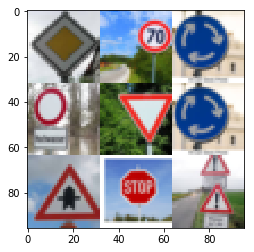

In [21]:
### I grabbed 13 images off the web.
### Here I'm showing a random selection of 9 of those
def get_image(image_path, resized_width=32, resized_height=32, mode='RGB'):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)
    image_shape = image.size
    width, height = image_shape
    minimum_dimension = min(image_shape)
    width_excess = width - minimum_dimension
    height_excess = height - minimum_dimension
    # left, upper, right, lower
    crop_rectangle = (width_excess // 2, height_excess // 2, width - (width_excess // 2), height - (height_excess // 2))
    #print(crop_rectangle)
    image = image.crop(crop_rectangle)
    image = image.resize([resized_width, resized_height], Image.BILINEAR)

    return np.array(image.convert(mode))

from glob import glob

web_images = np.array(list(map(get_image, glob('./german_traffic_signs/*.jpeg')))).astype(np.float32)

indexes = list(map(int, np.random.sample((9,)) * len(web_images)))
sample_images = web_images[indexes]
plt.imshow(images_square_grid(sample_images, 'RGB'))

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./traffic_signs


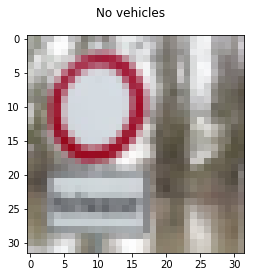

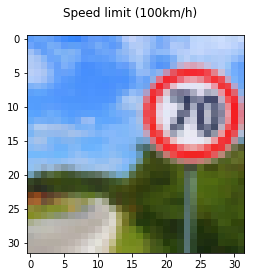

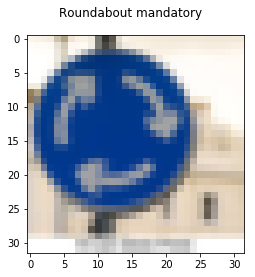

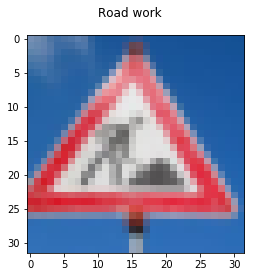

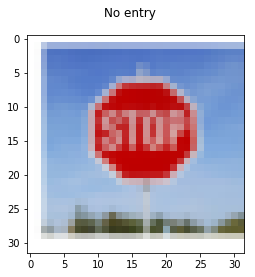

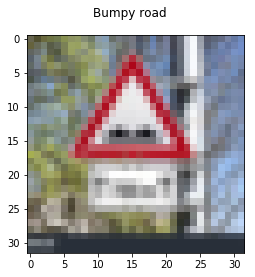

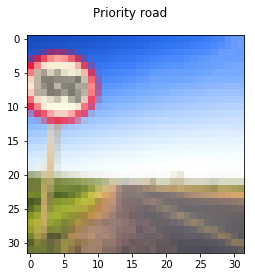

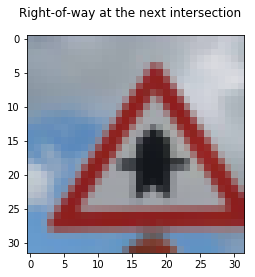

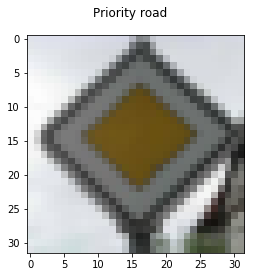

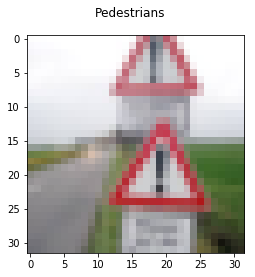

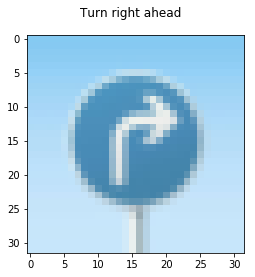

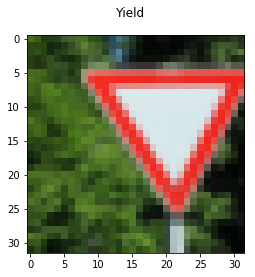

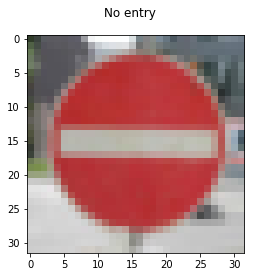

In [22]:
### Find the predicted classification for each web image

import pandas

sign_names = pandas.read_csv('./signnames.csv')

sign_name_map = {k: v for k, v in sign_names.values}

normalized_web_images = normalize_images(web_images)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    predictions = sess.run(output, feed_dict={x: normalized_web_images, is_train: False})
    
class_predictions = binarizer.inverse_transform(predictions)
#print(class_predictions)
    
for i in range(len(web_images)):
    prediction = class_predictions[i]
    plt.figure(i).suptitle(sign_name_map[prediction])
    plt.imshow(Image.fromarray(web_images[i].astype('uint8'), 'RGB'))
    

### Analyze Performance

In [58]:
# 10 images were correct. Print the percentage.

print("{}% correct".format(round(100. * 10. / len(web_images))))

77% correct


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./traffic_signs


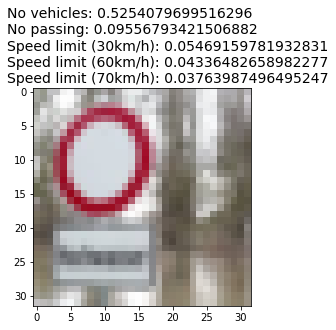

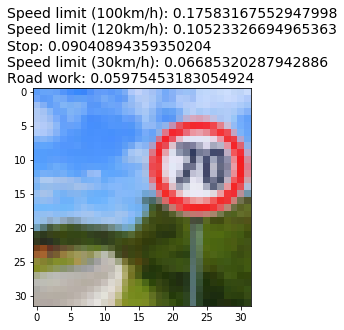

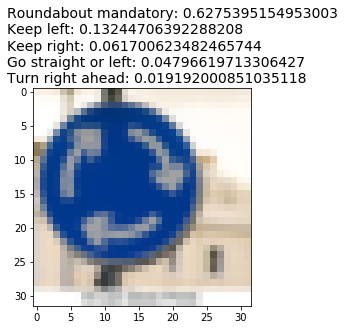

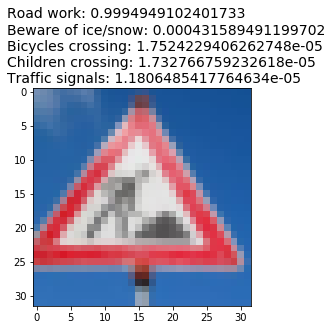

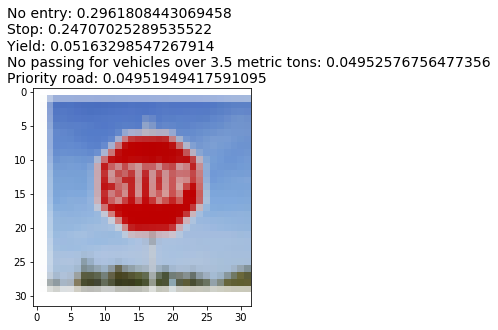

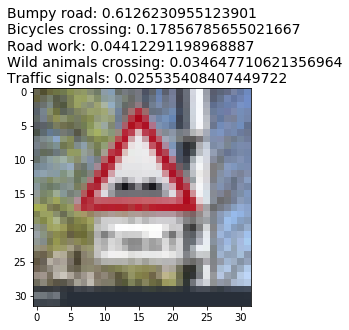

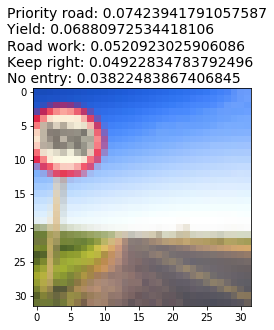

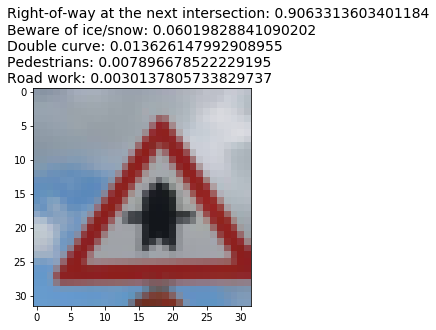

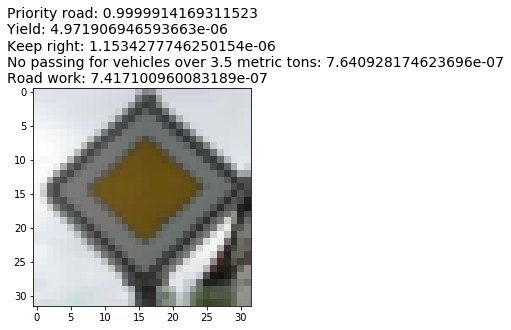

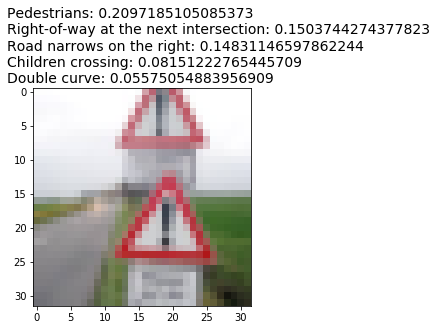

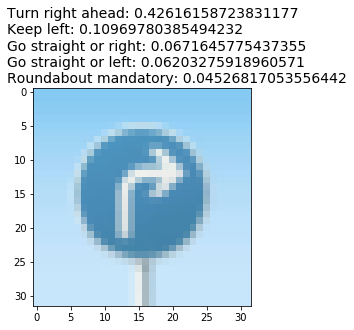

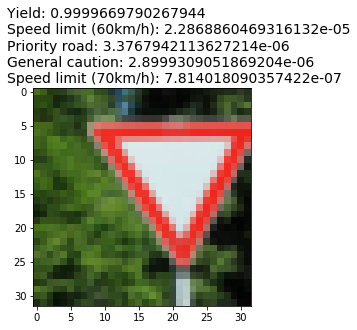

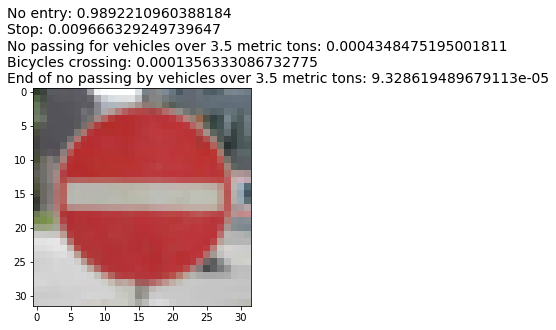

In [31]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    top_5_predictions = sess.run(tf.nn.top_k(output, k=5), feed_dict={x: normalized_web_images, is_train: False})


for i in range(len(web_images)):
    softmax_predictions = top_5_predictions[0][i]
    prediction_labels = top_5_predictions[1][i]
    prediction_names = [sign_name_map[p] for p in prediction_labels]
    title_string = "\n".join(["{}: {}".format(prediction_names[i], softmax_predictions[i]) for i in range(5)])
    #plt.figure(i).suptitle(title_string)
    figure = plt.figure(i)
    figure.text(0.2, 0.9, title_string, fontsize=14)
    plt.imshow(Image.fromarray(web_images[i].astype('uint8'), 'RGB'))

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


INFO:tensorflow:Restoring parameters from ./traffic_signs


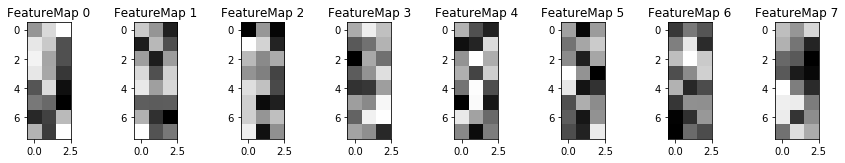

In [236]:
# With the use of tf.layers and my layers nested in a function,
# the available variables were not that great for visualization.
# What is shown is a kernel variable. While not very accessible,
# it is still fascinating to think that the shown apparently-random
# values produce useful information.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    #activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    activation = sess.run(tf_activation, feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
image_input = normalized_web_images[-1]

model_vars = tf.trainable_variables()
convolution_vars = [variable for variable in model_vars if len(variable.shape) == 4]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
 
    outputFeatureMap([image_input], convolution_vars[0])

In [52]:
## in order to get a better visualization, I set up a small convolutional network for quick training,
## with no pooling, in order to get good visualizations for all layers

def simple_model(images):
    conv1 = tf.layers.conv2d(images, 8, 5, padding='same', activation=None)
    conv1 = activation(conv1)

    conv2 = tf.layers.conv2d(conv1, 8, 5, padding='same', activation=None)
    conv2 = activation(conv2)

    conv3 = tf.layers.conv2d(conv2, 8, 5, padding='same', activation=None)
    conv3 = activation(conv3)
    
    flattened = tf.contrib.layers.flatten(conv3)
    
    fc3 = tf.layers.dense(flattened, 32)
    fc3 = activation(fc3)


    logits = tf.layers.dense(fc3, n_classes, activation=None)
    out = tf.nn.softmax(logits)

    return out, logits, conv1, conv2, conv3, fc3


simple_output, simple_logits, layer1, layer2, layer3, layer4 = simple_model(x)

simple_loss = model_loss(simple_logits, y)

simple_optimizer = tf.train.AdamOptimizer(learning_rate = 0.01)
simple_training_operation = optimizer.minimize(simple_loss)

In [47]:
simple_correct_prediction = tf.equal(tf.argmax(simple_output, 1), tf.argmax(y, 1))
simple_accuracy_operation = tf.reduce_mean(tf.cast(simple_correct_prediction, tf.float32))

def simple_evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy = sess.run(simple_accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [48]:
epochs = 4

from sklearn.utils import shuffle
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(epochs):
        X_train_normalized, y_train_onehot = shuffle(X_train_normalized, y_train_onehot)
        for offset in range(0, n_train, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train_normalized[offset:end], y_train_onehot[offset:end]
            sess.run(simple_training_operation, feed_dict={x: batch_x, y: batch_y})
            if (offset // batch_size) % 25 == 0:
                train_accuracy = simple_evaluate(batch_x, batch_y)
                print("Batch {} of {}. Training accuracy is {:.3f}".format(offset // batch_size, n_train // batch_size, train_accuracy))
            
        validation_accuracy = simple_evaluate(X_valid_normalized, y_valid_onehot)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    print('training complete')

Training...

Batch 0 of 543. Training accuracy is 0.016
Batch 25 of 543. Training accuracy is 0.109
Batch 50 of 543. Training accuracy is 0.031
Batch 75 of 543. Training accuracy is 0.156
Batch 100 of 543. Training accuracy is 0.188
Batch 125 of 543. Training accuracy is 0.250
Batch 150 of 543. Training accuracy is 0.266
Batch 175 of 543. Training accuracy is 0.266
Batch 200 of 543. Training accuracy is 0.219
Batch 225 of 543. Training accuracy is 0.391
Batch 250 of 543. Training accuracy is 0.422
Batch 275 of 543. Training accuracy is 0.469
Batch 300 of 543. Training accuracy is 0.469
Batch 325 of 543. Training accuracy is 0.406
Batch 350 of 543. Training accuracy is 0.438
Batch 375 of 543. Training accuracy is 0.516
Batch 400 of 543. Training accuracy is 0.422
Batch 425 of 543. Training accuracy is 0.625
Batch 450 of 543. Training accuracy is 0.547
Batch 475 of 543. Training accuracy is 0.562
Batch 500 of 543. Training accuracy is 0.672
Batch 525 of 543. Training accuracy is 0.516
EP

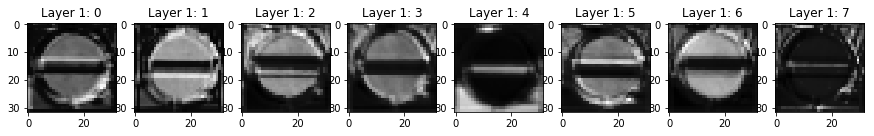

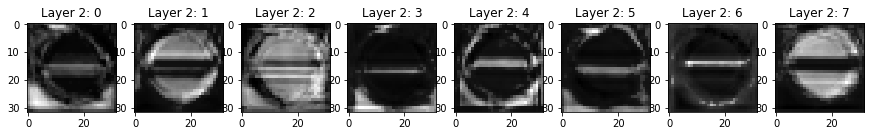

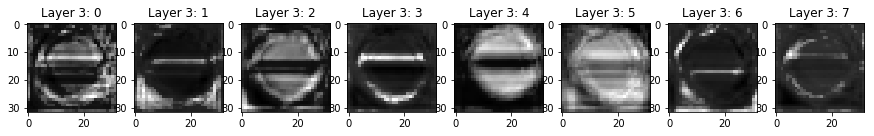

In [56]:
# visualize simple network

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1, plt_num=1, layer_name='FeatureMap '):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    #activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    activation = sess.run(tf_activation, feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title(layer_name + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# Do not enter sign.
# This sign had a strong prediction, so is likely to show clear features
image_input = normalized_web_images[-1]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    plot_number = 1
    for layer in [layer1, layer2, layer3]:
        outputFeatureMap([image_input], layer, plt_num=plot_number, layer_name = "Layer {}: ".format(plot_number))
        plot_number += 1